In [1]:
import h5py
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import geoarrow.pyarrow as ga
from geoarrow.pyarrow import io
import geopandas as gpd
import numpy as np

In [2]:
file = h5py.File("./ATL08_20230816225647_08822006_006_01.h5")

In [3]:
land_segments_group = file["gt1l"]["land_segments"]
canopy_group = file["gt1l"]["land_segments"]["canopy"]
terrain_group = file["gt1l"]["land_segments"]["terrain"] 

In [4]:
def datasets_to_fields(group: h5py.Group):
    fields = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            dtype = group[key].dtype
            numpy_dtype = dtype.newbyteorder("=")
            arrow_type = pa.from_numpy_dtype(numpy_dtype)
            fields.append((key, arrow_type))
    return fields

In [5]:
land_segment_fields = datasets_to_fields(land_segments_group)
geometry_field = pa.field("geometry", ga.point().with_crs("epsg:4326"))
land_segment_fields.append(geometry_field)

canopy_fields = datasets_to_fields(canopy_group)
terrain_fields = datasets_to_fields(terrain_group)

fields = land_segment_fields + canopy_fields + terrain_fields
schema = pa.schema(fields)
len(schema)

88

In [6]:
def get_group_chunks(group: h5py.Group, offset: int, chunk_size: int) -> list[np.array]:
    chunks = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            if len(group[key].chunks) == 1:
                chunks.append(group[key][offset:offset+chunk_size])
            # Handle variables with land segment chunking
            elif len(group[key].chunks) == 2:
                chunks.append(group[key][offset:offset+chunk_size, 0])
    return chunks

In [7]:
table_writer = pq.ParquetWriter('output.parquet', schema)

In [8]:
tables = []
files = ["ATL08_20230816225122_08822005_006_01.h5", "ATL08_20230816225647_08822006_006_01.h5"]
for file in files:
    file = h5py.File(file)
    land_segments_group = file["gt1l"]["land_segments"]
    canopy_group = file["gt1l"]["land_segments"]["canopy"]
    terrain_group = file["gt1l"]["land_segments"]["terrain"] 
    
    chunk_size = land_segments_group["latitude"].chunks[0]
    size = land_segments_group["latitude"].size
    number_of_chunks = (size // chunk_size) + 1
    for n in range(number_of_chunks):
        offset = n * chunk_size
        land_segment_chunks = get_group_chunks(land_segments_group, offset, chunk_size)
        # Populate geometry field
        geometries = []
        for lat, lon in zip(
            land_segments_group["latitude"][offset:offset+chunk_size],
            land_segments_group["longitude"][offset:offset+chunk_size]
        ):
            geometries.append((lon, lat))
        land_segment_chunks.append(geometries)
    
        canopy_chunks = get_group_chunks(canopy_group, offset, chunk_size)
        terrain_chunks = get_group_chunks(terrain_group, offset, chunk_size)
        chunks = land_segment_chunks + canopy_chunks + terrain_chunks
    
        table = pa.Table.from_arrays(chunks, schema=schema)
        tables.append(table)
        #table_writer.write_table(table)

In [9]:
combined_table = pa.concat_tables(tables)
table_writer.write_table(combined_table)
table_writer.close()

In [10]:
df = pd.read_parquet("output.parquet")
df

,asr,atlas_pa,beam_azimuth,beam_coelev,brightness_flag,cloud_flag_atm,cloud_fold_flag,delta_time,delta_time_beg,delta_time_end,...,h_te_min,h_te_mode,h_te_rh25,h_te_skew,h_te_std,h_te_uncertainty,n_te_photons,photon_rate_te,subset_te_flag,terrain_slope
0,0.000000,0.009584,-1.131079,1.561213,0,1,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-8.739319,-6.700000,-6.816865,-4.645024,0.276219,0.073758,92,0.657143,1,0.004414
1,0.000000,0.009585,-1.130966,1.561212,0,1,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-7.259439,-6.700000,-6.788824,-1.263107,0.142029,0.073177,92,0.657143,1,-0.000476
2,0.024370,0.009586,-1.132601,1.561211,0,2,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-7.665920,-6.900000,-7.152872,-0.766652,0.188859,0.105514,67,0.475177,1,0.000710
3,0.024370,0.009587,-1.132575,1.561210,0,2,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-7.882301,-7.100000,-7.164553,-0.921842,0.212597,0.133265,53,0.375887,1,0.001154
4,0.054386,0.009586,-1.132668,1.561210,0,2,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-7.954785,-7.000000,-7.147531,-1.984102,0.184919,0.074616,95,0.669014,1,-0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20759,0.054356,0.008721,-1.185785,1.562076,0,0,0,1.774622e+08,1.774622e+08,1.774622e+08,...,-38.189041,-37.500000,-37.699661,-0.036105,0.277915,0.277673,135,1.261682,1,0.006193
20760,0.054356,0.008721,-1.186008,1.562075,0,0,0,1.774622e+08,1.774622e+08,1.774622e+08,...,-37.984474,-37.600002,-37.561909,0.131762,0.283280,0.306079,122,1.051724,1,-0.005495
20761,0.062162,0.008721,-1.185915,1.562075,0,0,0,1.774622e+08,1.774622e+08,1.774622e+08,...,-37.890442,-37.500000,-37.528870,0.222038,0.269295,0.276355,135,1.125000,1,0.003886
20762,0.062162,0.008721,-1.185819,1.562075,0,0,0,1.774622e+08,1.774622e+08,1.774622e+08,...,-38.689686,-38.000000,-38.085407,0.072274,0.413675,0.268024,141,1.175000,1,-0.009325


<Axes: xlabel='longitude', ylabel='latitude'>

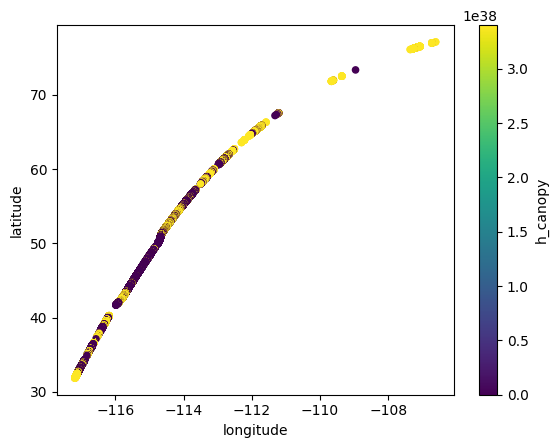

In [11]:
df.plot.scatter(x='longitude', y='latitude', c="h_canopy")

In [12]:
io.write_geoparquet_table(combined_table, "output.geoparquet")

In [13]:
gdf = gpd.read_parquet('output.geoparquet')
gdf

,asr,atlas_pa,beam_azimuth,beam_coelev,brightness_flag,cloud_flag_atm,cloud_fold_flag,delta_time,delta_time_beg,delta_time_end,...,h_te_min,h_te_mode,h_te_rh25,h_te_skew,h_te_std,h_te_uncertainty,n_te_photons,photon_rate_te,subset_te_flag,terrain_slope
0,0.000000,0.009584,-1.131079,1.561213,0,1,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-8.739319,-6.700000,-6.816865,-4.645024,0.276219,0.073758,92,0.657143,1,0.004414
1,0.000000,0.009585,-1.130966,1.561212,0,1,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-7.259439,-6.700000,-6.788824,-1.263107,0.142029,0.073177,92,0.657143,1,-0.000476
2,0.024370,0.009586,-1.132601,1.561211,0,2,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-7.665920,-6.900000,-7.152872,-0.766652,0.188859,0.105514,67,0.475177,1,0.000710
3,0.024370,0.009587,-1.132575,1.561210,0,2,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-7.882301,-7.100000,-7.164553,-0.921842,0.212597,0.133265,53,0.375887,1,0.001154
4,0.054386,0.009586,-1.132668,1.561210,0,2,0,1.774615e+08,1.774615e+08,1.774615e+08,...,-7.954785,-7.000000,-7.147531,-1.984102,0.184919,0.074616,95,0.669014,1,-0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20759,0.054356,0.008721,-1.185785,1.562076,0,0,0,1.774622e+08,1.774622e+08,1.774622e+08,...,-38.189041,-37.500000,-37.699661,-0.036105,0.277915,0.277673,135,1.261682,1,0.006193
20760,0.054356,0.008721,-1.186008,1.562075,0,0,0,1.774622e+08,1.774622e+08,1.774622e+08,...,-37.984474,-37.600002,-37.561909,0.131762,0.283280,0.306079,122,1.051724,1,-0.005495
20761,0.062162,0.008721,-1.185915,1.562075,0,0,0,1.774622e+08,1.774622e+08,1.774622e+08,...,-37.890442,-37.500000,-37.528870,0.222038,0.269295,0.276355,135,1.125000,1,0.003886
20762,0.062162,0.008721,-1.185819,1.562075,0,0,0,1.774622e+08,1.774622e+08,1.774622e+08,...,-38.689686,-38.000000,-38.085407,0.072274,0.413675,0.268024,141,1.175000,1,-0.009325


In [14]:
metadata = pq.read_metadata('output.parquet')
metadata

  created_by: parquet-cpp-arrow version 15.0.1
  num_columns: 89
  num_rows: 20764
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 18004